# Generalized Linear Models II, Demo 6

**Task 2**

Let's take a closer look at the main effect model of the Bacteria data. Solve the regression coefficients $\, \boldsymbol{\beta} = (\beta_0, \, \beta_1, \, \beta_2, \beta_3)^T \,$ using the **Fisher Scoring algorithm.** Compare the results to the $\, \beta \,$ coefficients given by fitting the same model using the statsmodels library.

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Bacteria = pd.read_csv("C:/Users/testi/Desktop/R_GLM2/Bacteria_data.csv", index_col=0)

In [3]:
Bacteria.head()

,Bcount,SOM,pH,Phosp
AB2,28,-0.670750,0.198666,1.913011
AB3,56,-0.670750,0.174232,1.329170
AB4,15,-1.158568,1.412185,-0.583841
AB5,76,-1.158568,0.719909,0.074533
AT2,29,-0.670750,-0.232989,1.676990


In [4]:
Bacteria.shape

(56, 4)

Let's first fit the Poisson regression model using the **GLM** function from the statsmodels library.

In [5]:
# Create the design matrix
X = Bacteria[["SOM", "pH", "Phosp"]]
X.insert(0, "Intercept", np.ones(len(X)))
X.head(2)

,Intercept,SOM,pH,Phosp
AB2,1.0,-0.67075,0.198666,1.913011
AB3,1.0,-0.67075,0.174232,1.329170


In [6]:
# Create the response variable
y = Bacteria["Bcount"]
y.head(2)

AB2    28
AB3    56
Name: Bcount, dtype: int64

In [7]:
fit1 = sm.GLM(y, X, family=sm.families.Poisson()).fit()

**The Fisher Scoring algorithm**

In [8]:
# Initialize the response variable and the design matrix
X = X.values
y = y.values


# Initialize Poisson function
def lam(eta):
    return np.exp(eta)

# Initialize beta and epsilon
beta = np.zeros(np.shape(X)[1]).T
eps = 0.001

while eps > 1e-4:
    # Compute the linear predictor
    eta = X @ beta
    
    # Compute the predicted probabilities
    mu = lam(eta)
    
    # Compute diagonal weight matrix
    W = np.diag(mu)
    
    # Calculate the score function (the first derivative of the log-likelihood) 
    # and the Fisher information matrix
    Score = X.T @ (y - mu)
    I = X.T @ W @ X
    
    # Iteration step
    beta_new = beta + np.linalg.inv(I) @ Score
    
    # Update eps for the while loop threshold criteria
    eps = (beta_new - beta).T @ (beta_new - beta)
    
    # Update beta
    beta = beta_new

Let's build up a dataframe and add two column vectors to it; the estimated $\, \mathbf{\beta} \,$ coefficients that we achieved using the **Fisher Scoring algorithm**, and the corresponding standard errors for the $\, \mathbf{\beta} \,$ coefficients.

Note that the **standard errors** for the **$\, \mathbf{\beta} \,$ coefficients** can be achived by taking the **square root of the diagonal elements of the inverse of the Fisher Information matrix**.

In [9]:
df1 = pd.DataFrame({"Beta coeff": beta,
                    "Standard error": np.sqrt(np.diag(np.linalg.inv(I)))},
                    index=["Intercept", "SOM", "pH", "Phoshp"])

In [10]:
df1

,Beta coeff,Standard error
Intercept,4.410129,0.014908
SOM,-0.219017,0.019412
pH,-0.027899,0.016759
Phoshp,-0.029035,0.016961


Now, let's compare these $\, \mathbf{\beta} \,$ coefficients and standard errors derived from the Fisher Scoring algorithm to the $\, \mathbf{\beta} \,$ coefficients and standard errors acquired from fitting the Poisson regression model using the **GLM** function from the **statsmodels** library.


A fitted GLM object from the statsmodels library has two attributes called **params** and **bse**, which return the model's $\, \beta \,$ coefficients and standard errors for the $\, \beta \,$ coefficients.

In [11]:
df2 = pd.DataFrame({"Beta coeff": fit1.params,
                    "Standard error": fit1.bse})

In [12]:
df2

,Beta coeff,Standard error
Intercept,4.410129,0.014908
SOM,-0.219017,0.019413
pH,-0.027899,0.016760
Phosp,-0.029035,0.016961


- The Fisher scoring algorithm and the fitted model return almost identical $\, \beta \,$ coefficients and standard errors for the $\, \beta \,$ coefficients.

**Task 3**

Let's study the relationship between environmental factors and the abundance of a specific butterfly species.

Using a Poisson regression model, determine how the number of butterflies changes each year, how environmental factors affect the number of butterflies, and whether the change in butterfly numbers differs across different environments.

Ensure proper model selection by excluding any explanatory variables that do not improve the model's performance. Display the results graphically.

In [13]:
data = pd.read_csv("C:/Users/testi/Desktop/R_GLM2/Butterfly_data.csv", index_col=0)

In [14]:
data.head(3)

,site,time,habitat,building,Colias
1,1,1,Mixed,2.12,2
2,1,2,Mixed,2.12,0
3,1,3,Mixed,2.12,1


- site**:** observation location
- time**:** year
- habitat**:** grassland type (hayfield, mixed, short, tall)
- building**:** the percentage of buildings in the environment
- Colias**:** the number of the butterflies in the area **(response variable)**

In [15]:
data.dtypes

site          int64
time          int64
habitat      object
building    float64
Colias        int64
dtype: object

In [16]:
data.shape

(330, 5)

To see if two or more explanatory variables are highly correlated (i.e. the correlation is close to 1 or -1), one can create a correlation matrix that shows the correlation coefficients between each pair of explanatory variables. If there are high correlations between the explanatory variables, it may be appropriate to exclude one of them from the model.

- Pandas DataFrames have a **corr()** method, which creates the correlation matrix between all of the possible variable pairings in the dataframe.

In [17]:
np.round(data.corr(), 3)

,site,time,building,Colias
site,1.000,-0.00,-0.149,-0.053
time,-0.000,1.00,0.000,0.190
building,-0.149,0.00,1.000,-0.139
Colias,-0.053,0.19,-0.139,1.000


- None of the explanatory variables seem to be highly correlated with each other.
- Since there are no high correlations between the explanatory variables, there are no need to exclude any of them from the model.

One can compare two nested model's for example via deviance test or by comparing the AIC (Akaike Information Criterion) / BIC (Bayesian Information Criterion) values.

Let **M1** and **M2** be nested models. Then, null hypothesis and alternative hypothesis for the **deviance test** are

<center>$H_0 :$ "model $\boldsymbol{M1}$ is the best model"<center>

    
<center>$H_1 :$ "model $\boldsymbol{M2}$ is the best model",<center>

where **M2** has the same explanatory variables as **M1**, but in addition to that, more terms (e.g. interaction terms or more explanatory variables) has been added to it.

The Deviance test statistic is given by

$$ D_{test} = D_1 - D_2 \sim \chi^2_{\Delta \, in \, \# \, \beta's} $$


where $\, D_1 \,$ and $\, D_2 \,$ are the Deviance residuals for the models $\, \boldsymbol{M1} \,$ and $\, \boldsymbol{M2}. \,$

The **deviance residual** for a logistic regression model can be calculated as follows

\begin{align}
Deviance_{residual} &= 2(LL(Saturated \, model) - LL(Proposed \, model)) \\
&= 2(-LL(Proposed \, model))
\end{align}

<center>, $where \: \, LL = Log-Likelihood$.</center>

In the statsmodels library, a fitted Poisson regression model has an attribute called $\, \boldsymbol{llf}, \,$ which returns the **log-likelihood** value of the model.

In [18]:
model1 = sm.formula.glm("Colias ~ time + habitat", 
                        family=sm.families.Poisson(), 
                        data=data).fit()

In [19]:
model2 = sm.formula.glm("Colias ~ time + habitat + building", 
                        family=sm.families.Poisson(), 
                        data=data).fit()

In [20]:
def model_statistics(M1, M2):
    """Returns the deviance test statistic, 
       p value for the statistic, AIC, and BIC for both models."""
    
    dev_M1 = 2*(-M1.llf)
    dev_M2 = 2*(-M2.llf)
    D_test = dev_M1 - dev_M2
    df = abs(len(M1.params) - len(M2.params))
    p_val = 1 - scipy.stats.chi2.cdf(D_test, df)
    stat_frame = pd.DataFrame({"Test statistic": [D_test],
                               "p-value": [p_val],
                               "M1 AIC": [M1.aic],
                               "M1 BIC": [M1.bic],
                               "M2 AIC": [M2.aic],
                               "M2 BIC": [M2.bic]})
    return stat_frame

- The degrees of freedom for the $\, \chi^2 \,$ distribution is the difference in the number of the $\, \beta \,$ coefficients between the models.


- The AIC penalizes models that are too complex by adding a penalty term to the log-likelihood. The lower the AIC value, the better the model is at balancing goodness of fit and model complexity. In general, if two models explain the same amount of variation, the one with fewer parameters will have a lower AIC score. Therefore, when comparing different regression models, the one with the lower AIC is considered to be a better fit for the data.


- The BIC favors simpler models than the AIC by penalizing models with more parameters more heavily than the AIC. A lower BIC value indicates a better fit to the data.


- Model selection: The BIC and AIC may lead to different model selections in certain situations. In general, the BIC tends to favor simpler models than the AIC, while the AIC tends to favor more complex models if they provide a better fit to the data.


- As for the p-value regarding the deviance test, if one gets a p-value smaller than any commonly used threshold (e.g. p < 0.05), then one can reject the null hypothesis and conclude that deviance the test supports the alternative hypothesis (the model with more parameters is the better model).

In [21]:
statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF(True)
model_statistics(model1, model2)

,Test statistic,p-value,M1 AIC,M1 BIC,M2 AIC,M2 BIC
0,16.953433,0.000038,1916.077564,1935.073027,1901.124131,1923.918686


- Now, since the p-value is ~ 0.000038, the null hypothesis can be safely rejected. Therefore it can be concluded that **Model2** is the better model.


- The AIC and BIC values both support this conclusion, since they are both smaller for Model2.

- It is worth noting that the exact situation as described above (the BIC and AIC may lead  to different model selections in certains situations) has happened here. If one were to choose the model based on AIC and BIC values alone, they would need to have a deep understanding of the data and the goal of the regression analysis, since the AIC indicates that Model1 is the better model, and the BIC indicates that Model2 is the better model.

In [22]:
model3 = sm.formula.glm("Colias ~ habitat + building", 
                        family=sm.families.Poisson(), 
                        data=data).fit()

In [23]:
model_statistics(model3, model2)

,Test statistic,p-value,M1 AIC,M1 BIC,M2 AIC,M2 BIC
0,143.014012,0.0,2042.138142,2061.133605,1901.124131,1923.918686


- Again, model2 is the better model.

In [24]:
model4 = sm.formula.glm("Colias ~ time + building", 
                        family=sm.families.Poisson(), 
                        data=data).fit()

In [25]:
model_statistics(model4, model2)

,Test statistic,p-value,M1 AIC,M1 BIC,M2 AIC,M2 BIC
0,916.239449,0.0,2811.363579,2822.760857,1901.124131,1923.918686


- model2 is the better model.

Now, let's add some interaction terms.

In [26]:
model5 = sm.formula.glm("Colias ~ time + habitat + building + time*habitat", 
                        family=sm.families.Poisson(), 
                        data=data).fit()

In [27]:
model_statistics(model2, model5)

,Test statistic,p-value,M1 AIC,M1 BIC,M2 AIC,M2 BIC
0,50.656882,5.788814e-11,1901.124131,1923.918686,1856.467248,1890.659082


- model5 with the interaction term is the better model.

In [28]:
model6 = sm.formula.glm("Colias ~ time + habitat + building + time*building", 
                        family=sm.families.Poisson(), 
                        data=data).fit()

In [29]:
model_statistics(model6,  model5)

,Test statistic,p-value,M1 AIC,M1 BIC,M2 AIC,M2 BIC
0,45.121876,1.591876e-10,1897.589124,1924.182772,1856.467248,1890.659082


- model5 is the better model. Let's choose model5 as the final model.

In [30]:
model5.params

Intercept                1.246026
habitat[T.Mixed]        -0.612555
habitat[T.Short]        -1.019969
habitat[T.Tall]         -0.601128
time                     0.377303
time:habitat[T.Mixed]   -0.259374
time:habitat[T.Short]   -0.549106
time:habitat[T.Tall]    -0.226533
building                -0.048614
dtype: float64

In [31]:
ci = np.exp(model5.conf_int())
ci = ci.rename(columns={0: "lower", 1: "upper"})
ci

,lower,upper
Intercept,2.755699,4.385839
habitat[T.Mixed],0.356365,0.824227
habitat[T.Short],0.195544,0.665001
habitat[T.Tall],0.375517,0.800271
time,1.374837,1.546929
time:habitat[T.Mixed],0.688898,0.864084
time:habitat[T.Short],0.473855,0.703731
time:habitat[T.Tall],0.720188,0.882654
building,0.929647,0.976015


Does the number of observed colias change annually?

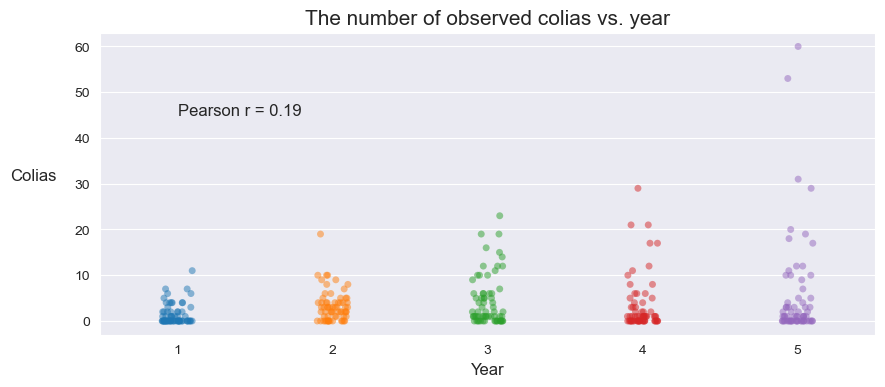

In [32]:
plt.figure(figsize=(10, 4), dpi=100)
sns.set_style("darkgrid")
sns.stripplot(x="time", y="Colias", alpha=0.5, data=data)
plt.xlabel("Year", size=12)
plt.ylabel("Colias", rotation=0, labelpad=30, size=12)
plt.title("The number of observed colias vs. year", size=15)

# Add the pearson correlation coefficient between time and Colias to the plot.
r = np.round(scipy.stats.pearsonr(data["time"], data["Colias"])[0], 3)

plt.annotate(f"Pearson r = {r}", xy=(0, 45), size=12);

- There seems to be a some kind of connection between the number of observed colias and the year.

- A strip plot is a type of plot that displays the distribution of a continuous variable in a dataset.
- It is a simple scatterplot with one categorical variable and one continuous variable. 
- The categorical variable is used to group the data points, with each group represented by a distinct set of points along the x-axis. This allows us to see how the distribution of the continuous variable differs across the different groups.
- Unlike swarmplot, strip plot allows overlapping of the data points, so when using strip plot, it's always a good idea to adjust the transparency of the data points.

Does environmental factors affect the number of observed colias?

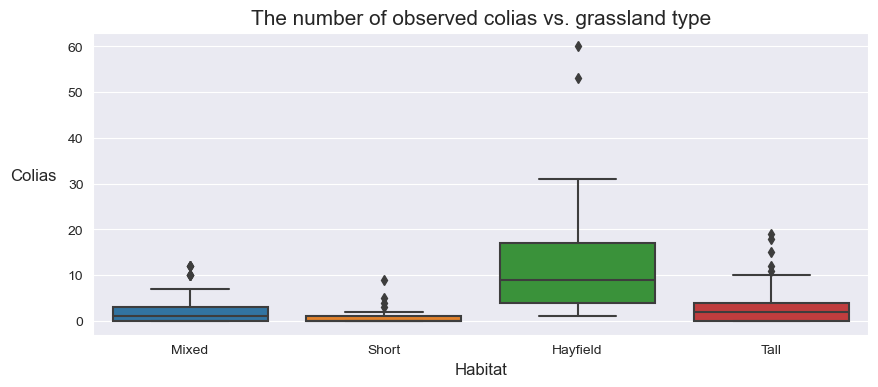

In [33]:
plt.figure(figsize=(10, 4), dpi=100)
sns.boxplot(x="habitat", y="Colias", data=data)

plt.xlabel("Habitat", size=12)
plt.ylabel("Colias", rotation=0, labelpad=25, size=12)
plt.title("The number of observed colias vs. grassland type", size=15);

In [34]:
Colias_mixed = data[data["habitat"] == "Mixed"]["Colias"].values.sum()
print(f"The number of observed colias in mixed grassland type: {Colias_mixed}")

The number of observed colias in mixed grassland type: 209


In [35]:
Colias_short = data[data["habitat"] == "Short"]["Colias"].values.sum()
print(f"The number of observed colias in short grassland type: {Colias_short}")

The number of observed colias in short grassland type: 56


In [36]:
Colias_hayfield = data[data["habitat"] == "Hayfield"]["Colias"].values.sum()
print(f"The number of observed colias in hayfield grassland type: {Colias_hayfield}")

The number of observed colias in hayfield grassland type: 659


In [37]:
Colias_tall = data[data["habitat"] == "Tall"]["Colias"].values.sum()
print(f"The number of observed colias in tall grassland type: {Colias_tall}")

The number of observed colias in tall grassland type: 288


In [38]:
hayfield_percentage = Colias_hayfield / (Colias_mixed + Colias_short + Colias_hayfield + Colias_tall)
np.round(hayfield_percentage, 2)

0.54

- As seen from the graph and from the calculations above, there seems to be a connection between the number of observed colias and the grassland type. **54 %** of the colias have been observed in hayfield.

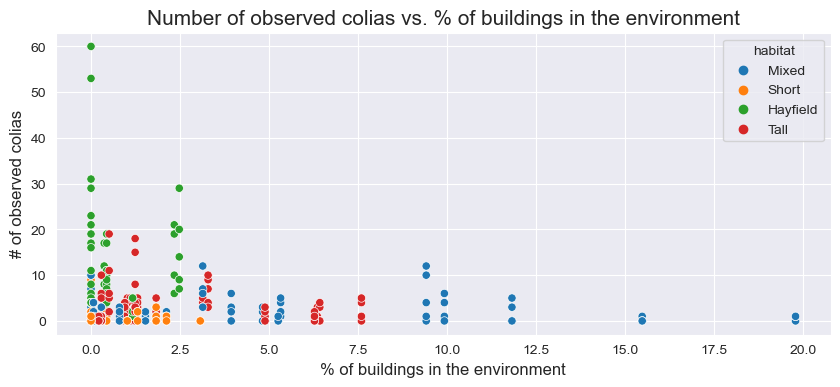

In [39]:
plt.figure(figsize=(10, 4), dpi=100)
sns.scatterplot(x="building", y="Colias", hue="habitat", data=data)

plt.xlabel("% of buildings in the environment", size=12)
plt.ylabel("# of observed colias", size=12)
plt.title("Number of observed colias vs. % of buildings in the environment", size=15);

- It is clear that when there are less buildings in the environment, there are more colias observations.

In conclusion:
- There is a moderate association between the year and the number of colias observed.
- There is a strong association between the environmental factors and the number of colias observed.

**Task 4**

In the case of the previous task, present the $\, \beta \,$ coefficients as risk ratios (relative changes in the expected value of the response).

$$ log \, (\lambda_i) = X_i^T \vec{\beta} \: \: \: \: \: \: ,where \: \, \lambda_i = E \, (y_i). $$

To interpret the $\, \beta \,$ coefficients as risk ratios, one should compare situtations where the values of the input variable $X_i$ differs by one unit.

$$ \frac{\lambda_1}{\lambda_2} = \frac{e^{\hat{\beta_0}\, + \, \hat{\beta_1} (x+1) \, + \, ...}} {e^{\hat{\beta_0}\, + \, \hat{\beta_1} x \, + \, ...}} = \boldsymbol{e^{\hat{\beta_1}}} $$

In [40]:
b = np.exp(model5.params)

In [41]:
b

Intercept                3.476500
habitat[T.Mixed]         0.541964
habitat[T.Short]         0.360606
habitat[T.Tall]          0.548193
time                     1.458347
time:habitat[T.Mixed]    0.771535
time:habitat[T.Short]    0.577466
time:habitat[T.Tall]     0.797293
building                 0.952549
dtype: float64

In [42]:
b[1]

0.5419643726550194

- It can be inferred from the exponentiated value of $\, \boldsymbol{\beta_1} \,$ that one can expect to observe 0.542 times as much colias in mixed grassland compared to hayland (the reference group), when adjusting for other explanatory variables (time and building). This means that the comparison is eligible only when the comparison is done in the same year and when there is the same amount of buildings in the environment.

- The interpretation for $\, \boldsymbol{\beta_2} \,$ and $\, \boldsymbol{\beta_3} \,$ is the same as for $\, \boldsymbol{\beta_1}, \,$ except that now one compares short grassland type and tall grassland type to hayland. In both cases, the expected number of observed colias decreases when moving from hayland to short grassland / tall grassland. 

In [43]:
b[4]

1.4583466965804999

- When year increases by one unit (e.g. 2020 $\rightarrow$ 2021), one can expect that the number of observed colias increase by a factor of 1.458, when adjusting for the other explanatory variables.

In [44]:
b[8]

0.95254916789198

- When the percentage of buildings in the environment increases by one unit (e.g. from 5 % to 6 %), one can expect that the number of observed colias changes by a factor of 0.953 (e.g. if there are 100 observed colias when the building % is 5, then one can expect to observe 95 colias when the building % is 6.) 

In [45]:
b[4] * b[5]

1.1251650638774864

- (This is the same as $\, \boldsymbol{e^{\beta_4 \, + \, \beta_5}}. \,$)


- For each unit increase in time, the rate of the outcome variable is multiplied by $\, \beta_4. \,$ However, this effect of time on the outcome variable depends on the level of the habitat variable (grassland type). When the habitat is mixed, the effect of time on the outcome variable (response variable, dependent variable) is multilpied $\, \beta_5. \,$


- In conclusion, when the grassland type is mixed, and time increases by one unit (one year), one can except that the rate of the outcome variable (number of observed colias) is multiplied by 1.125.

**Task 5**

In the case of the previous task, 

**1.** How would you test the null hypothesis that "the expected values of the observed colias in the different grassland types are the same"? 

**2.** How would you test pair-wise differences in the grassland types? For example, how would you test the null hypothesis that "the expected values of the observed colias in mixed and tall grassland types are the same"?

One can test these hypotheses via **F-test**, which is most often used when comparing statistical models that have been fitted to a data set, in order to identify the model that best fits the population from which the data were sampled.

In [46]:
def F_test(K, X, beta, sigma):
    q = np.linalg.matrix_rank(np.linalg.qr(K)[0])
    n = X.shape[0]
    p = X.shape[1]
    F = (K.T @ beta).T @ np.linalg.inv(K.T @ np.linalg.inv(X.T @ X) @ K) @ (K.T @ beta) / (q * sigma)
    p_val = 1 - scipy.stats.f.cdf(F, q, n-p-1)
    if round(p_val, ndigits=5) == 0:
        p_val = "< 0.000"
    frame = pd.DataFrame({"F": [F], "p-value": p_val})
    return frame

In [47]:
# Create the design matrix. 
# Note that one has to perform binary encoding for the habitat variable,
# since it is a categorical variable with 4 categories.
X0 = np.ones(len(data))
X1 = data["time"].values
X2 = data["building"].values
X3 = np.where(data["habitat"] == "Tall", 1, 0)
X4 = np.where(data["habitat"] == "Mixed", 1, 0)
X5 = np.where(data["habitat"] == "Short", 1, 0)
X6 = np.where(data["habitat"] == "Hayfield", 1, 0)
X_design = pd.DataFrame({"X0": X0,
                         "X1": X1,
                         "X2": X2,
                         "X3": X3,
                         "X4": X4,
                         "X5": X5,
                         "X6": X6})
X_design = X_design.values

In [48]:
X_design[0:5, 0:7]

array([[1.  , 1.  , 2.12, 0.  , 1.  , 0.  , 0.  ],
       [1.  , 2.  , 2.12, 0.  , 1.  , 0.  , 0.  ],
       [1.  , 3.  , 2.12, 0.  , 1.  , 0.  , 0.  ],
       [1.  , 4.  , 2.12, 0.  , 1.  , 0.  , 0.  ],
       [1.  , 5.  , 2.12, 0.  , 1.  , 0.  , 0.  ]])

In [49]:
X_design.shape

(330, 7)

In [50]:
# Response variable
Colias = data["Colias"].values

In [51]:
Colias.shape

(330,)

In [52]:
beta = sm.GLM(Colias, X_design).fit().params
beta

array([ 1.58426335,  0.88636364, -0.10032331, -1.25867018, -1.53666877,
       -3.4282671 ,  7.80786941])

In [53]:
resid = Colias - X_design @ beta
n = len(X_design)
p = beta.shape[0] - 1
sigmahat_squared = (resid.T @ resid) / (n-p-1)

$ H_0 : $ "the expected values of the observed colias in the different grassland types are the same".
- In other words, $\, H_0 : $ $\, \beta_3 = \beta_4 = \beta_5 = \beta_6 \,$
- This can then be rearranged to $\, H_0 : $ $\, \beta_3 - \beta_4 - \beta_5 - \beta_6 = 0 \,$
- This equation can be formed as a linear combination of the matrix K and and the beta vector. 

$ H_1 : $ "Atleast one expected value in the different grassland types differs from the others".

In [54]:
K = np.column_stack(np.array([[0, 0, 0, 1, -1, -1, -1]]))

- Now one can clearly see that the linear combination of K and beta gives the rearranged equation as stated above.

In [55]:
F_test(K, X_design, beta, sigmahat_squared)

,F,p-value
0,1.057793e-15,1.0


- ?????

**Task 6**

In [85]:
fit_nb = sm.formula.glm("Colias ~ time + habitat + building + time*habitat", 
                        family=sm.families.NegativeBinomial(), 
                        data=data).fit()

In [82]:
fit_poisson = sm.formula.glm("Colias ~ time + habitat + building + time*habitat", 
                             family=sm.families.Poisson(), 
                             data=data).fit()

In [86]:
fit_nb.params

Intercept                1.290398
habitat[T.Mixed]        -0.722685
habitat[T.Short]        -0.941778
habitat[T.Tall]         -0.705041
time                     0.366256
time:habitat[T.Mixed]   -0.214616
time:habitat[T.Short]   -0.581614
time:habitat[T.Tall]    -0.192762
building                -0.055758
dtype: float64

In [83]:
fit_poisson.params

Intercept                1.246026
habitat[T.Mixed]        -0.612555
habitat[T.Short]        -1.019969
habitat[T.Tall]         -0.601128
time                     0.377303
time:habitat[T.Mixed]   -0.259374
time:habitat[T.Short]   -0.549106
time:habitat[T.Tall]    -0.226533
building                -0.048614
dtype: float64

- Tulokset muuttuvat, mutta ei mitään hajua, miksi ne muuttuvat?

**Task 7**

**a)** Let's examine the number of deaths from cardiovascular diseases per 100000 working-age individuals. Draw the number of deaths for both men and women per 100000 working-age individuals in the same graph between the years 1970-2014.

- To calculate the desired death rates, one can divide the number of deaths in each group by its total population, and then multiply the results by 100000.

In [56]:
BCD = pd.read_csv("C:/Users/testi/Desktop/R_GLM2/Blood_circulation_data.csv", index_col=0)

In [57]:
BCD.head()

,vuosi,sukup,kuolleet,vaki
3,1970,0,4820,1490486
4,1970,1,1944,1561812
5,1971,0,5148,1511124
6,1971,1,1964,1577136
7,1972,0,4718,1530217


- vuosi: year
- sukup: gender (0 = man, 1 = woman)
- kuolleet: deaths from cardiovascular diseases (excluding alcohol-related diseases)
- vaki: the number of working-age (25-64 years old) people

In [58]:
BCD.dtypes

vuosi       int64
sukup       int64
kuolleet    int64
vaki        int64
dtype: object

In [59]:
BCD["vuosi"].min()

1970

In [60]:
BCD["vuosi"].max()

2014

In [61]:
BCD["sukup"].value_counts()

0    45
1    45
Name: sukup, dtype: int64

In [62]:
men = BCD[BCD["sukup"] == 0]

In [63]:
women = BCD[BCD["sukup"] == 1]

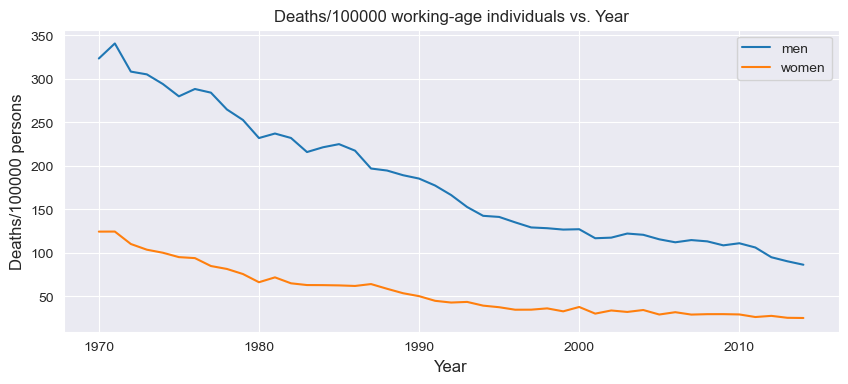

In [64]:
plt.figure(figsize=(10, 4), dpi=100)

sns.lineplot(x="vuosi", y=(men["kuolleet"] / men["vaki"]) * 100000, label="men", data=BCD)
sns.lineplot(x="vuosi", y=(women["kuolleet"] / women["vaki"]) * 100000, label="women", data=BCD)

plt.xlabel("Year", size=12)
plt.ylabel("Deaths/100000 persons", size=12)
plt.title("Deaths/100000 working-age individuals vs. Year", size=12)
plt.legend(loc="upper right");

**b)** Fit a Poisson regression model to the data, where the input variables are the year 1970, gender, and the interaction between year 1970 and gender. What is the expected number of deaths per 100,000 working-age men and women in 1970 according to the model? How much has the mortality rate decreased annually for men and women? Please provide the confidence intervals as well.

In [70]:
year_1970 = BCD[BCD["vuosi"] == 1970]

In [71]:
year_1970

,vuosi,sukup,kuolleet,vaki
3,1970,0,4820,1490486
4,1970,1,1944,1561812


In [73]:
# fit1970 = sm.formula.glm("kuolleet ~ vuosi + sukup + vuosi*sukup",
#                          offset=np.log10(year_1970["vaki"]),
#                          family=sm.families.Poisson(),
#                          data=year_1970).fit()

- En ymmärrä, miten voi sovittaa ainoastaan vuoden 1970. Jos laitan pelkästään vuoden 1970, niin Python antaa virheen "PerfectSeparationError: Perfect separation detected, results not available", joka tarkottaa sitä, että malli ennustaa vastemuuttujaa täydellisesti.